In [134]:
import pandas as pd          
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime    
from pandas import Series 
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
%matplotlib inline
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False
import seaborn as sns
sns.set(style="darkgrid")

In [135]:
sales_data = pd.read_csv("./示例数据/order_train1.csv")
test  = pd.read_csv("./示例数据/predict_sku1.csv")

In [136]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102


In [137]:
sales_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59769 entries, 0 to 59768
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   order_date         59769 non-null  object 
 1   sales_region_code  59769 non-null  int64  
 2   item_code          59769 non-null  int64  
 3   first_cate_code    59769 non-null  int64  
 4   second_cate_code   59769 non-null  int64  
 5   sales_chan_name    59769 non-null  object 
 6   item_price         59769 non-null  float64
 7   ord_qty            59769 non-null  int64  
dtypes: float64(1), int64(5), object(2)
memory usage: 3.6+ MB


In [138]:
sales_data.describe()

,sales_region_code,item_code,first_cate_code,second_cate_code,item_price,ord_qty
count,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000,59769.000000
mean,102.895581,21005.448560,304.937325,406.440295,1074.334474,91.443139
std,1.500799,592.082875,2.007037,3.107452,966.881714,195.407986
min,101.000000,20001.000000,301.000000,401.000000,1.000000,1.000000
25%,102.000000,20512.000000,303.000000,404.000000,597.000000,10.000000
50%,103.000000,20973.000000,306.000000,407.000000,880.280000,29.000000
75%,105.000000,21518.000000,306.000000,408.000000,1291.000000,101.000000
max,105.000000,22084.000000,308.000000,412.000000,47911.000000,12480.000000


# 1. Data cleaning

## Remove outliers

<AxesSubplot: xlabel='item_price'>

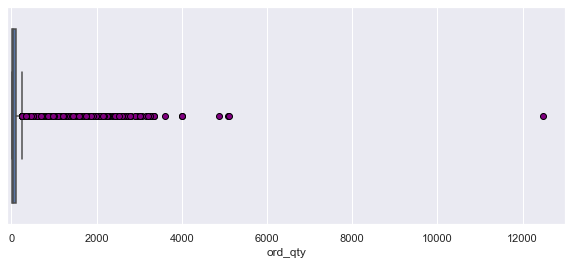

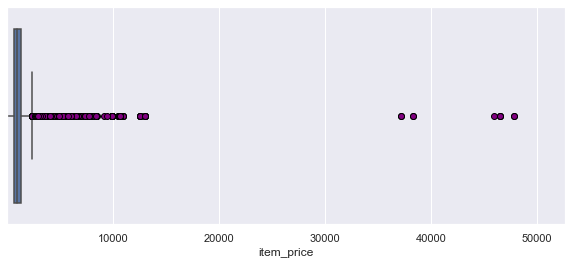

In [139]:
# 销售量
plt.figure(figsize=(10,4))
plt.xlim(-100, 13000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=sales_data.ord_qty, flierprops=flierprops)

# 价格
plt.figure(figsize=(10,4))
plt.xlim(sales_data.item_price.min(), sales_data.item_price.max()*1.1)
sns.boxplot(x=sales_data.item_price, flierprops=flierprops)

- 去除销量大于4000的以及价格大于30000的
    - 其实这里还需要验证一下去除的那几条记录，是不是好的，因为可能有些商品就是卖这么多或者怎样
    - 验证一下test集里有没有出现

In [140]:
sales_data = sales_data[(sales_data.item_price < 30000 )& (sales_data.ord_qty < 4000)]

In [141]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015/9/2,104,20028,301,405,offline,1005.0,11
1,2015/9/3,102,20354,303,401,offline,1420.0,64
2,2015/9/4,101,20586,306,407,offline,978.0,7
3,2015/9/4,101,20230,306,407,offline,864.0,66
4,2015/9/4,105,21619,306,402,online,274.0,102


## 数据类型处理

In [142]:
# 时间 object->datetime格式
sales_data["order_date"]=sales_data["order_date"].apply(pd.to_datetime,format='%Y-%m-%d')

In [143]:
# 线上0 线下1
dic = {"offline":1,"online":0}
sales_data['sales_chan_name'] = sales_data['sales_chan_name'].map(dic)

In [144]:
# 单独的item代码，以及其对应的记录条数
train_item = np.unique(sales_data["item_code"],return_counts=True)
train_item

(array([20001, 20002, 20003, ..., 22082, 22083, 22084]),
 array([  2,  73, 285, ...,  15,  32,  57]))

In [145]:
# 当然这是做了异常值处理之后的
print('Unique item codes:', len(sales_data['item_code'].unique()))  # 1421种
print('大类编码', sales_data["first_cate_code"].unique())  # 8大类
print('细类编码', sales_data["second_cate_code"].unique()) # 12小类
print('地区编码', sales_data["sales_region_code"].unique()) # 5个地区


Unique item codes: 1421
大类编码 [301 303 306 305 302 307 308 304]
细类编码 [405 401 407 402 412 408 403 410 404 409 406 411]
地区编码 [104 102 101 105 103]


## 检验这四类code是否一一对应
对后续如何处理很关键

In [146]:
# 大类和细类是否一一对应
grouped_data = sales_data.groupby(['first_cate_code', 'second_cate_code']).size() #.reset_index(name='counts')
print(len(grouped_data))
grouped_data
# 发现大类和细类是一一对应的

12


first_cate_code  second_cate_code
301              405                  2230
302              408                  9339
303              401                  6014
                 406                   544
                 410                   473
                 411                   156
304              409                   981
305              412                  7486
306              402                  1242
                 407                 20690
307              403                  5167
308              404                  5431
dtype: int64

In [147]:
# 统计每个second_cate_code中包含的商品种类数量
second_cate_count = sales_data.groupby('second_cate_code')['item_code'].nunique().reset_index(name='counts')
# second_cate_count
# 统计每个商品所属的second_cate_code数量，并检查是否有某个商品只属于一个second_cate_code
item_counts = sales_data.groupby('item_code')['second_cate_code'].nunique()
unique_items = item_counts[item_counts == 1].index.tolist()
if len(unique_items) > 0:
    print(f"有 {len(unique_items)} 种商品只属于一个second_cate_code")
else:
    print("所有商品都属于多个second_cate_code")

# 输出每个second_cate_code中包含的商品数量
print("每个second_cate_code中包含的商品数量：")
print(second_cate_count)

有 1421 种商品只属于一个second_cate_code
每个second_cate_code中包含的商品数量：
    second_cate_code  counts
0                401     155
1                402      11
2                403     125
3                404     117
4                405      28
5                406      14
6                407     398
7                408     324
8                409      51
9                410      27
10               411       7
11               412     164


In [148]:
## 地区和商品
# 统计每个sales_region_code中包含的商品种类数量
sales_region_count = sales_data.groupby('sales_region_code')['item_code'].nunique().reset_index(name='counts')
# second_cate_count
# 统计每个商品所属的sales_region_code数量，并检查是否有某个商品只属于一个sales_region_code
item_counts = sales_data.groupby('item_code')['sales_region_code'].nunique()
unique_items = item_counts[item_counts == 1].index.tolist()
two_items = item_counts[item_counts == 2].index.tolist()
three_items = item_counts[item_counts == 3].index.tolist()
four_items = item_counts[item_counts == 4].index.tolist()
five_items = item_counts[item_counts == 5].index.tolist()
if len(unique_items) > 0:
    print(f"有 {len(unique_items)} 种商品只在一个地区销售")
if len(two_items) > 0:
    print(f"有 {len(two_items)} 种商品在两个地区销售")
if len(three_items) > 0:  
    print(f"有 {len(three_items)} 种商品在三个地区销售")
if len(four_items) > 0:
    print(f"有 {len(four_items)} 种商品在四个地区销售")
if len(five_items) > 0:
    print(f"有 {len(five_items)} 种商品在五个地区销售")

# 输出每个sales_region_code中包含的商品数量
print("每个sales_region_codee中包含的商品数量：")
print(sales_region_count)

有 332 种商品只在一个地区销售
有 265 种商品在两个地区销售
有 300 种商品在三个地区销售
有 456 种商品在四个地区销售
有 68 种商品在五个地区销售
每个sales_region_codee中包含的商品数量：
   sales_region_code  counts
0                101     930
1                102     951
2                103     896
3                104     170
4                105     979


- 简单总结
   - 一级分类和二级分类是一对多的
   - 每个商品只有一个类别，不会对用多种
   - 1421 种商品中，只有 332 种商品是只在一个地区销售的，其他的都在多个地区销售

## 编码label_encoding
- 将地区、item_code、类别进行顺序编码

In [149]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-02,104,20028,301,405,1,1005.0,11
1,2015-09-03,102,20354,303,401,1,1420.0,64
2,2015-09-04,101,20586,306,407,1,978.0,7
3,2015-09-04,101,20230,306,407,1,864.0,66
4,2015-09-04,105,21619,306,402,0,274.0,102


这里test有train中没有的商品类别
包括
> y contains previously unseen labels: [20011, 20025, 20198, 20273, 20324, 20401, 20449, 20456, 20469, 20503, 20549, 20701, 20721, 20736, 20750, 20793, 20841, 20869, 20951, 20999, 21085, 21184, 21393, 21416, 21523, 21606, 21667, 21687, 21823, 21867, 21879, 21954, 22075]

所以就先不对item code进行编码了

In [150]:

from sklearn.preprocessing import LabelEncoder
# 地区
LE1 = LabelEncoder()
sales_data["sales_region_code"] = LE1.fit_transform(sales_data.sales_region_code )
test["sales_region_code"] = LE1.transform(test.sales_region_code)
# itemcode
# LE2 = LabelEncoder()
# sales_data["item_code"] = LE2.fit_transform(sales_data.item_code )
# test["item_code"] = LE2.transform( test.item_code )
# 大类
LE3 = LabelEncoder()
sales_data["first_cate_code"] = LE3.fit_transform(sales_data.first_cate_code )
test["first_cate_code"] = LE3.transform( test.first_cate_code )
# 细类
LE4 = LabelEncoder()
sales_data["second_cate_code"] = LE4.fit_transform(sales_data.second_cate_code )
test["second_cate_code"] = LE4.transform( test.second_cate_code )




In [151]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty
0,2015-09-02,3,20028,0,4,1,1005.0,11
1,2015-09-03,1,20354,2,0,1,1420.0,64
2,2015-09-04,0,20586,5,6,1,978.0,7
3,2015-09-04,0,20230,5,6,1,864.0,66
4,2015-09-04,4,21619,5,1,0,274.0,102


# 2. Preprocessing

- 按照月份递增的顺序，创建一个包含月份、地区和商品的组合的矩阵df。
    - Item_cnt_day（ord_qty）被求和为Item_cnt_month。
- product()函数也可以用于求取一个可迭代对象中自己各个元素的全排列组合

- 因为每一个月，每个region种所出售的item情况不同，很多时候可能是0（没有这个记录），但是这都要参与到我们的建模中。所以我们要先将所有的情况都列出来。然后再与现有数据合并，缺失的数据就填补为0，这样构建数据集

- ？？？
- 这里暂时按月合成的时候，先忽略线上、线下的因素，全部一股脑合并先，需要补充eda，对不同商品线上线下销售情况进行EDA，再进行分析

In [152]:
# 生成一列月份编号
sales_data["month"] = sales_data.order_date.dt.month
sales_data["year"] = sales_data.order_date.dt.year
sales_data["date_block_num"] = (sales_data["year"]-sales_data["year"].min())*12+sales_data["month"]-9 # 减8是因为第一个月是9月份

# 输出结果
del sales_data["month"],sales_data["year"]

In [153]:
# sales_data.head()
sales_data.tail()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,date_block_num
59764,2018-12-20,2,20337,1,7,1,799.0,2,39
59765,2018-12-20,2,20146,5,1,1,327.0,87,39
59766,2018-12-20,2,21911,5,6,1,1006.0,2,39
59767,2018-12-20,1,21195,1,7,1,1855.0,134,39
59768,2018-12-20,1,21596,1,7,1,1103.0,108,39


In [154]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num","sales_region_code", "item_code"]
for i in range(40):
    sales = sales_data[sales_data.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.sales_region_code.unique(), sales.item_code.unique()) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols ) # 堆叠
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["sales_region_code"] = matrix["sales_region_code"].astype(np.int8)
matrix["item_code"] = matrix["item_code"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts 

0.18015789985656738

In [155]:
# add revenue to train df 收入
sales_data["revenue"] = sales_data["item_price"] * sales_data["ord_qty"]

In [156]:
ts = time.time()
group = sales_data.groupby( ["date_block_num", "sales_region_code", "item_code"] ).agg( {"ord_qty": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True) # 这一步重置索引，直接把层级索引转换为列
matrix = pd.merge( matrix, group, on = cols, how = "left" ) # 转换后，二者就可以merge了
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16) # 填补缺失值
time.time() - ts

0.04078412055969238

In [157]:
# matrix就是每月、每个地区、每个商品的销量
matrix.head()

,date_block_num,sales_region_code,item_code,item_cnt_month
0,0,0,20003,0.0
1,0,0,20007,0.0
2,0,0,20008,13.0
3,0,0,20009,159.0
4,0,0,20013,0.0


- 为第40个月设置一下test集

In [158]:
# 对测试集添加一个月份列，同时设置一下三列的数据格式
test["date_block_num"] = 40
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["sales_region_code"] = test.sales_region_code.astype(np.int8)
test["item_code"] = test.item_code.astype(np.int16)

- 合并训练集和测试集

In [159]:
map_cate_df = sales_data[["first_cate_code","second_cate_code","item_code"]].drop_duplicates()
map_cate_df.head()

,first_cate_code,second_cate_code,item_code
0,0,4,20028
1,2,0,20354
2,5,6,20586
3,5,6,20230
4,5,1,21619


In [160]:
# matrix.head()

In [161]:
# 给matrix补充上类别属性
matrix = pd.merge(matrix, map_cate_df, on = ["item_code"], how = "left")
matrix["first_cate_code"] = matrix["first_cate_code"].astype(np.int8)
matrix["second_cate_code"] = matrix["second_cate_code"].astype(np.int8)

In [162]:
# matrix.head()

In [163]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,0,20003,0.0,0,4
1,0,0,20007,0.0,4,11
2,0,0,20008,13.0,2,0
3,0,0,20009,159.0,5,6
4,0,0,20013,0.0,2,0
...,...,...,...,...,...,...
66680,39,4,22072,145.0,4,11
66681,39,4,22080,0.0,5,6
66682,39,4,22081,0.0,2,0
66683,39,4,22083,8.0,2,0


In [164]:
# 合并训练和测试
ts = time.time()
# cols  = ["date_block_num","sales_region_code", "item_code"]

matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) # 按三列，添加？
matrix.fillna( 0, inplace = True )
time.time() - ts

0.0032799243927001953

In [165]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code
0,0,0,20003,0.0,0,4
1,0,0,20007,0.0,4,11
2,0,0,20008,13.0,2,0
3,0,0,20009,159.0,5,6
4,0,0,20013,0.0,2,0
...,...,...,...,...,...,...
66942,40,4,21884,0.0,5,6
66943,40,4,21954,0.0,1,7
66944,40,4,22045,0.0,1,7
66945,40,4,22050,0.0,7,3


#  3. Feature Engineering

## 3.1 Add lag features to matrix df.

In [166]:
# Define a lag feature function
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "sales_region_code","item_code",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "sales_region_code","item_code", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=["date_block_num", "sales_region_code","item_code"], how='left')
    return df

- Add item_cnt_month lag features

In [167]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] ) # 添加该商店的该商品一个月、两个月、三个月的销量
time.time() - ts

item_cnt_month


0.09412789344787598

- Add the previous month's average item_cnt. 上个月的平均销量

In [168]:
ts = time.time()
# 计算每个月的平均销量（这个月的所有大杂烩）
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

# 在matrix中添加  前一个月的平均销量 作为一个lag feature
matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


0.05635714530944824

- Add lag values of item_cnt_month for month / item_id.

In [169]:
ts = time.time()
# 计算每个月该商品的平均销量（这个月的该商品）
group = matrix.groupby(['date_block_num', 'item_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

# 添加 前三个月该商品的平均销量
matrix = pd.merge(matrix, group, on=['date_block_num','item_code'], how='left')
matrix.date_item_avg_item_cnt = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3], ['date_item_avg_item_cnt'])
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_item_avg_item_cnt


0.1360330581665039

- Add lag values for item_cnt_month for every month / region combination.

In [170]:
ts = time.time()
# 计算 该地区的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_region_avg_item_cnt"] )
matrix.drop( ["date_region_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_region_avg_item_cnt


<ipython-input-170-1f9a7b212985>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_avg_item_cnt"].astype(np.float16)


0.12448406219482422

- Add lag values for item_cnt_month for month/region/item.

In [171]:
ts = time.time()
# 计算每月该地区、该商品的平均销量
group = matrix.groupby( ["date_block_num","sales_region_code","item_code"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_region_item_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num","sales_region_code","item_code"], how = "left")
matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1,2,3], ["date_region_item_avg_item_cnt"] )
matrix.drop( ["date_region_item_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

<ipython-input-171-4c9cee418e72>:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  matrix.date_avg_item_cnt = matrix["date_region_item_avg_item_cnt"].astype(np.float16)


date_region_item_avg_item_cnt


0.1886141300201416

- Add lag values for item_cnt_month for month/region/item second_cate(subtype).

In [172]:
ts = time.time()
# 计算每月该地区、该子类商品的 销售量
group = matrix.groupby(['date_block_num', 'sales_region_code', 'second_cate_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_region_subtype_avg_item_cnt']
group.reset_index(inplace=True)

# 添加上一月的
matrix = pd.merge(matrix, group, on=['date_block_num', 'sales_region_code', 'second_cate_code'], how='left')
matrix.date_region_subtype_avg_item_cnt = matrix['date_region_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], ['date_region_subtype_avg_item_cnt'])
matrix.drop(['date_region_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

date_region_subtype_avg_item_cnt


0.09426712989807129

- 其实还可以补充一个大类商品的销售情况（有需要再说吧）

## 3.2 add price trend feature
* Add average item price on to matix df. 
* Add lag values of item price per month.
* Add delta price values - how current month average pirce relates to global average.

前面算的一直是销量，这里开始添加的特征是价格
虽然要求预测的是销量，但是价格与销量息息相关，也是重要的特征

Price trend features，最后只有一个'delta_price_lag'特征，具体看代码注释

In [173]:
matrix.columns

Index(['date_block_num', 'sales_region_code', 'item_code', 'item_cnt_month',
       'first_cate_code', 'second_cate_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3',
       'date_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_2', 'date_item_avg_item_cnt_lag_3',
       'date_region_avg_item_cnt_lag_1', 'date_region_avg_item_cnt_lag_2',
       'date_region_avg_item_cnt_lag_3', 'date_region_item_avg_item_cnt_lag_1',
       'date_region_item_avg_item_cnt_lag_2',
       'date_region_item_avg_item_cnt_lag_3',
       'date_region_subtype_avg_item_cnt_lag_1'],
      dtype='object')

In [174]:
sales_data.head()

,order_date,sales_region_code,item_code,first_cate_code,second_cate_code,sales_chan_name,item_price,ord_qty,date_block_num,revenue
0,2015-09-02,3,20028,0,4,1,1005.0,11,0,11055.0
1,2015-09-03,1,20354,2,0,1,1420.0,64,0,90880.0
2,2015-09-04,0,20586,5,6,1,978.0,7,0,6846.0
3,2015-09-04,0,20230,5,6,1,864.0,66,0,57024.0
4,2015-09-04,4,21619,5,1,0,274.0,102,0,27948.0


In [175]:
ts = time.time()
# 添加该商品的平均价格
group = sales_data.groupby( ["item_code"] ).agg({"item_price": ["mean"]})
group.columns = ["item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge( group, on = ["item_code"], how = "left" )
matrix["item_avg_item_price"] = matrix.item_avg_item_price.astype(np.float16)



# 添加该商品每月的平均价格，前三个月的
group = sales_data.groupby( ["date_block_num","item_code"] ).agg( {"item_price": ["mean"]} )
group.columns = ["date_item_avg_item_price"]
group.reset_index(inplace = True)

matrix = matrix.merge(group, on = ["date_block_num","item_code"], how = "left")
matrix["date_item_avg_item_price"] = matrix.date_item_avg_item_price.astype(np.float16)
lags = [1, 2, 3]
matrix = lag_feature( matrix, lags, ["date_item_avg_item_price"] ) # 添加价格
for i in lags: # 添加价格趋势
    matrix["delta_price_lag_" + str(i) ] = (matrix["date_item_avg_item_price_lag_" + str(i)]- matrix["item_avg_item_price"] )/ matrix["item_avg_item_price"]


def select_trends(row) :
    for i in lags:
        if row["delta_price_lag_" + str(i)]:
            return row["delta_price_lag_" + str(i)]
    return 0

# 这个函数看起来像是，该商品有上一个月的趋势，就取上一个月的。有上上个月的，就取上上个月的。。。如果前三个月都没有销售的价格，那么就取0
matrix["delta_price_lag"] = matrix.apply(select_trends, axis = 1)
matrix["delta_price_lag"] = matrix.delta_price_lag.astype( np.float16 )
matrix["delta_price_lag"].fillna( 0 ,inplace = True)

# 删除该商品的平均价格，商品的每月平均价格，和每月价格趋势。最后仅仅保留了一个delta_price_lag
features_to_drop = ["item_avg_item_price", "date_item_avg_item_price"]
for i in lags:
    features_to_drop.append("date_item_avg_item_price_lag_" + str(i) )
    features_to_drop.append("delta_price_lag_" + str(i) )
matrix.drop(features_to_drop, axis = 1, inplace = True)
time.time() - ts

date_item_avg_item_price


0.8409719467163086

* Add total shop revenue per month to matix df. 
* Add lag values of revenue per month.
* Add delta revenue values - how current month revenue relates to global average.

我们已经知道validation set和test set都会出现train set所没有的新商品，借助商店revenue趋势特征可以帮助算法预测新商品在现有店铺的销量

该商店的特征同上，但是泰迪杯没有这样的商店列，所以可以用大类或者小类的商品销售趋势替代
暂时用的是细类，其实可以优化为细类和地区的组合

In [176]:
matrix

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,date_item_avg_item_cnt_lag_2,date_item_avg_item_cnt_lag_3,date_region_avg_item_cnt_lag_1,date_region_avg_item_cnt_lag_2,date_region_avg_item_cnt_lag_3,date_region_item_avg_item_cnt_lag_1,date_region_item_avg_item_cnt_lag_2,date_region_item_avg_item_cnt_lag_3,date_region_subtype_avg_item_cnt_lag_1,delta_price_lag
0,0,0,20003,0.0,0,4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1,0,0,20007,0.0,4,11,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
2,0,0,20008,13.0,2,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
3,0,0,20009,159.0,5,6,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
4,0,0,20013,0.0,2,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66942,40,4,21884,0.0,5,6,9.0,NaN,137.0,50.28125,...,NaN,34.25,55.25,NaN,125.8125,9.0,NaN,137.0,92.31250,0.024216
66943,40,4,21954,0.0,1,7,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
66944,40,4,22045,0.0,1,7,9.0,0.0,0.0,50.28125,...,45.5,32.00,55.25,86.8125,125.8125,9.0,0.0,0.0,25.21875,-0.042603
66945,40,4,22050,0.0,7,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [177]:
ts = time.time()
group = sales_data.groupby( ["date_block_num","second_cate_code"] ).agg({"revenue": ["sum"] })
group.columns = ["date_subtype_revenue"]
group.reset_index(inplace = True)

matrix = matrix.merge( group , on = ["date_block_num", "second_cate_code"], how = "left" )
matrix['date_subtype_revenue'] = matrix['date_subtype_revenue'].astype(np.float32)

group = group.groupby(["second_cate_code"]).agg({ "date_block_num":["mean"] })
group.columns = ["subtype_avg_revenue"]
group.reset_index(inplace = True )

matrix = matrix.merge( group, on = ["second_cate_code"], how = "left" )
matrix["subtype_avg_revenue"] = matrix.subtype_avg_revenue.astype(np.float32)
matrix["delta_revenue"] = (matrix['date_subtype_revenue'] - matrix['subtype_avg_revenue']) / matrix['subtype_avg_revenue']
matrix["delta_revenue"] = matrix["delta_revenue"]. astype(np.float32)

matrix = lag_feature(matrix, [1], ["delta_revenue"])
matrix["delta_revenue_lag_1"] = matrix["delta_revenue_lag_1"].astype(np.float32)
matrix.drop( ["date_subtype_revenue", "subtype_avg_revenue", "delta_revenue"] ,axis = 1, inplace = True)
time.time() - ts

delta_revenue


0.11164212226867676

- Add month and number of days in each month to matrix df.

添加月份、和该月有多少天的两个特征

In [178]:
matrix["month"] = (matrix["date_block_num"]+9) % 12 # 9个月开始
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

Add the month of each shop and item first sale.

'item_subtype_last_sale'和'item_subtype_sale'用以纪录距离最近一次销售之间隔了几个月，通过它可以和之前月份的数据建立关联。'item_subtype_first_sale'和'item_first_sale'则是用于表示新商品的特征

该商品从第一个销售到现在有几个月了

In [179]:
ts = time.time()
matrix["item_subtype_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code","second_cate_code"])["date_block_num"].transform('min')
matrix["item_first_sale"] = matrix["date_block_num"] - matrix.groupby(["item_code"])["date_block_num"].transform('min')
time.time() - ts

0.010750055313110352

Delete first three months from matrix. They don't have lag values.

In [180]:
ts = time.time()
matrix = matrix[matrix["date_block_num"] > 3]
time.time() - ts

0.014406919479370117

In [181]:
matrix.head().T

,5660,5661,5662,5663,5664
date_block_num,4.000000,4.0,4.000000,4.000000,4.00000
sales_region_code,0.000000,0.0,0.000000,0.000000,0.00000
item_code,20003.000000,20005.0,20006.000000,20008.000000,20009.00000
item_cnt_month,0.000000,0.0,0.000000,14.000000,0.00000
first_cate_code,0.000000,5.0,6.000000,2.000000,5.00000
second_cate_code,4.000000,6.0,2.000000,0.000000,6.00000
item_cnt_month_lag_1,0.000000,NaN,0.000000,0.000000,NaN
item_cnt_month_lag_2,0.000000,NaN,0.000000,25.000000,0.00000
item_cnt_month_lag_3,0.000000,NaN,0.000000,49.000000,205.00000
date_avg_item_cnt_lag_1,98.000000,NaN,98.000000,98.000000,NaN


In [182]:
matrix.fillna(0)  #需要吗

,date_block_num,sales_region_code,item_code,item_cnt_month,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,...,date_region_item_avg_item_cnt_lag_1,date_region_item_avg_item_cnt_lag_2,date_region_item_avg_item_cnt_lag_3,date_region_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_subtype_first_sale,item_first_sale
5660,4,0,20003,0.0,0,4,0.0,0.0,0.0,98.00000,...,0.0,0.0,0.0,0.00000,-0.126343,4.566936e+04,1,28,4,4
5661,4,0,20005,0.0,5,6,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000e+00,1,28,0,0
5662,4,0,20006,0.0,6,2,0.0,0.0,0.0,98.00000,...,0.0,0.0,0.0,0.00000,0.298340,4.229956e+04,1,28,3,3
5663,4,0,20008,14.0,2,0,0.0,25.0,49.0,98.00000,...,0.0,25.0,49.0,133.25000,-0.021255,5.851814e+05,1,28,4,4
5664,4,0,20009,0.0,5,6,0.0,0.0,205.0,0.00000,...,0.0,0.0,205.0,0.00000,0.000000,0.000000e+00,1,28,4,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66942,40,4,21884,0.0,5,6,9.0,0.0,137.0,50.28125,...,9.0,0.0,137.0,92.31250,0.024216,1.407772e+06,1,28,9,9
66943,40,4,21954,0.0,1,7,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000e+00,1,28,0,0
66944,40,4,22045,0.0,1,7,9.0,0.0,0.0,50.28125,...,9.0,0.0,0.0,25.21875,-0.042603,5.049561e+05,1,28,6,6
66945,40,4,22050,0.0,7,3,0.0,0.0,0.0,0.00000,...,0.0,0.0,0.0,0.00000,0.000000,0.000000e+00,1,28,40,40


# 3.Modelling

In [183]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [184]:
data = matrix.copy()  # 使用copy，不要直接=
del matrix
gc.collect() # 释放内存

105

In [185]:
data.date_block_num

5660      4
5661      4
5662      4
5663      4
5664      4
         ..
66942    40
66943    40
66944    40
66945    40
66946    40
Name: date_block_num, Length: 61287, dtype: int8

Use month 38、39 as validation for training.

In [186]:
X_train = data[data.date_block_num < 38].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 38]['item_cnt_month']
X_valid = data[data.date_block_num.isin([38,39])].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num.isin([38,39])]['item_cnt_month']
X_test = data[data.date_block_num == 40].drop(['item_cnt_month'], axis=1)

In [187]:
# Y_train.head()

<AxesSubplot: xlabel='item_cnt_month'>

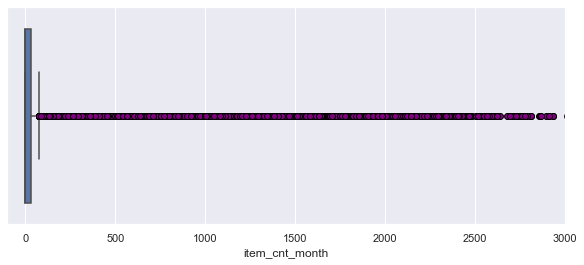

In [188]:
# 测一下数据分布，不知道这里是否需要归一化
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=Y_train, flierprops=flierprops)



In [189]:
# 划分完就删删删
del data
gc.collect();

In [190]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:295.81505	validation_1-rmse:250.45058
[1]	validation_0-rmse:281.04249	validation_1-rmse:242.45326
[2]	validation_0-rmse:268.53915	validation_1-rmse:235.25111


/Users/xuan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/xuan/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[3]	validation_0-rmse:256.03508	validation_1-rmse:228.22274
[4]	validation_0-rmse:244.88718	validation_1-rmse:226.05396
[5]	validation_0-rmse:234.66756	validation_1-rmse:223.69876
[6]	validation_0-rmse:225.44172	validation_1-rmse:223.07017
[7]	validation_0-rmse:216.85678	validation_1-rmse:222.37332
[8]	validation_0-rmse:209.56192	validation_1-rmse:220.63077
[9]	validation_0-rmse:202.86164	validation_1-rmse:220.42785
[10]	validation_0-rmse:196.55247	validation_1-rmse:221.21661
[11]	validation_0-rmse:190.60216	validation_1-rmse:220.23480
[12]	validation_0-rmse:185.61742	validation_1-rmse:219.56205
[13]	validation_0-rmse:181.31951	validation_1-rmse:219.32974
[14]	validation_0-rmse:176.69033	validation_1-rmse:220.03224
[15]	validation_0-rmse:172.91666	validation_1-rmse:221.88966
[16]	validation_0-rmse:169.40874	validation_1-rmse:223.36110
[17]	validation_0-rmse:166.30641	validation_1-rmse:223.91690
[18]	validation_0-rmse:163.16312	validation_1-rmse:224.43355
[19]	validation_0-rmse:160.3043

1.6628999710083008

In [196]:
X_valid

,date_block_num,sales_region_code,item_code,first_cate_code,second_cate_code,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,date_avg_item_cnt_lag_1,date_item_avg_item_cnt_lag_1,...,date_region_item_avg_item_cnt_lag_1,date_region_item_avg_item_cnt_lag_2,date_region_item_avg_item_cnt_lag_3,date_region_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days,item_subtype_first_sale,item_first_sale
62977,38,0,20002,2,5,0.0,0.0,0.0,103.4375,8.00,...,0.0,0.0,0.0,0.700195,-0.132690,1.641558e+04,11,31,22,22
62978,38,0,20003,0,4,82.0,17.0,0.0,103.4375,329.25,...,82.0,17.0,0.0,21.718750,0.167603,2.929482e+05,11,31,38,38
62979,38,0,20006,6,2,0.0,0.0,0.0,103.4375,84.25,...,0.0,0.0,0.0,167.625000,0.074158,6.898582e+05,11,31,37,37
62980,38,0,20014,6,2,NaN,0.0,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,0.000000,NaN,11,31,20,20
62981,38,0,20016,2,0,4.0,106.0,7.0,103.4375,14.75,...,4.0,106.0,7.0,103.375000,0.077454,9.059359e+05,11,31,23,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66680,39,4,22072,4,11,181.0,NaN,NaN,93.5000,45.25,...,181.0,NaN,NaN,45.062500,-0.008942,3.383652e+05,0,31,1,1
66681,39,4,22080,5,6,NaN,NaN,0.0,NaN,NaN,...,NaN,NaN,0.0,NaN,0.000000,NaN,0,31,39,39
66682,39,4,22081,2,0,0.0,9.0,0.0,93.5000,2.50,...,0.0,9.0,0.0,50.781250,-0.125854,8.394374e+05,0,31,13,13
66683,39,4,22083,2,0,20.0,2620.0,71.0,93.5000,5.50,...,20.0,2620.0,71.0,50.781250,-0.055817,8.394374e+05,0,31,5,5


In [198]:
Y_pred = model.predict(X_valid)
Y_test = model.predict(X_test)

submission = pd.DataFrame({
#     "ID": Y_valid.index, 
    "date_block_num":X_valid.date_block_num,
    "sales_region_code":X_valid.sales_region_code,
    "item_code":X_valid.item_code,
    "first_cate_code":X_valid.first_cate_code,
    "second_cate_code":X_valid.second_cate_code,
    "item_cnt_month_valid": Y_valid,
    "item_cnt_month_pred": Y_pred
})
submission.to_csv('xgb_submission.csv', index=False)

In [200]:
X_train.shape

(57317, 25)

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

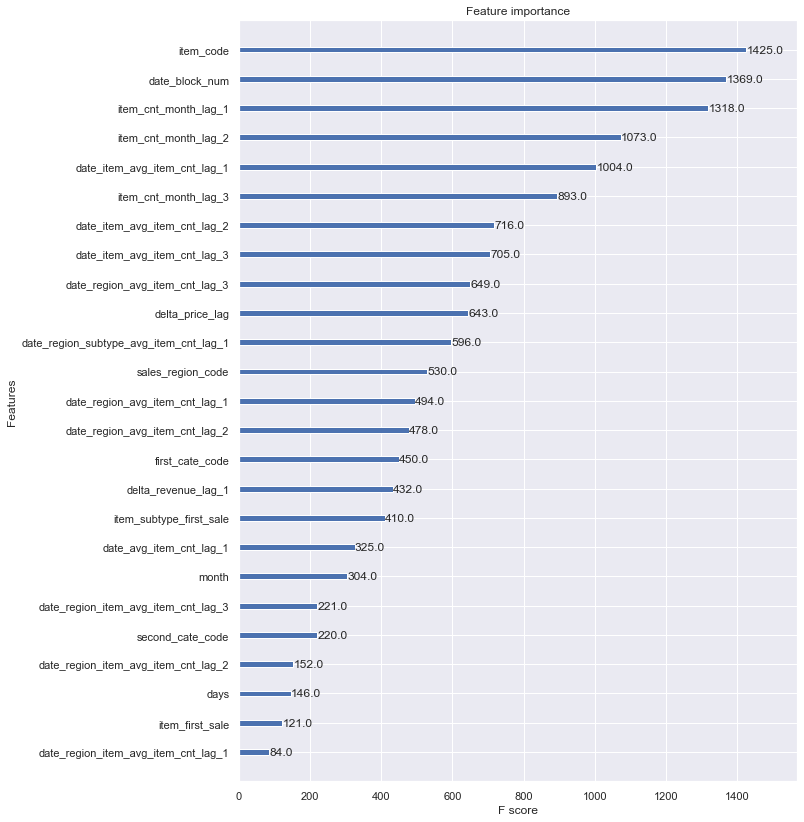

In [201]:
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

plot_features(model, (10,14))

<AxesSubplot: >

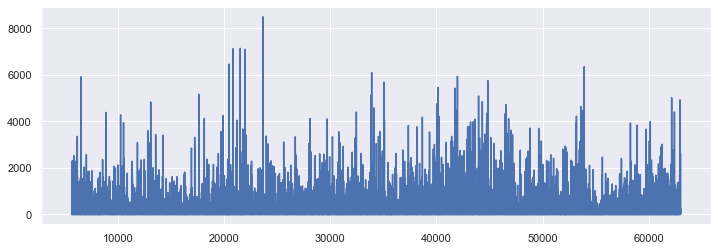

In [203]:
Y_train[].plot()

In [204]:
Y_train

5660        0.0
5661        0.0
5662        0.0
5663       14.0
5664        0.0
          ...  
62972       0.0
62973     264.0
62974       9.0
62975    2620.0
62976       0.0
Name: item_cnt_month, Length: 57317, dtype: float16